In [2]:
import bs4 as bs
import pickle
import requests

import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt
from matplotlib import style

import numpy as np
from collections import Counter

from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

/home/ibra/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    
    return tickers

# print (len(save_sp500_tickers()))
# save_sp500_tickers()

In [3]:
def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
            
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start = dt.datetime(2000,1,1)
    end = dt.datetime(2016,12,31)
    
    for ticker in tickers: #tickers[:10]
        try:
            print(ticker)
            if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
                df = web.DataReader(ticker, 'yahoo', start, end)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
            else:
                print('Already have {}'.format(ticker))
        except:
            print('Cannot obtain data for '+ticker)
    
#get_data_from_yahoo()    

In [4]:
def compile_data():
    with open("sp500tickers.pickle","rb") as f:
        tickers = pickle.load(f)
        
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        
        df.rename(columns = {'Adj Close': ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
            
        if count % 10 == 0:
            print(count)
            
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
       
#compile_data()   

           MMM       ABT      ABBV       ACN      ATVI       AYI      ADBE  \
MMM   1.000000  0.948820  0.917590  0.966734  0.926825  0.962077  0.931914   
ABT   0.948820  1.000000  0.870608  0.960316  0.889755  0.898102  0.877691   
ABBV  0.917590  0.870608  1.000000  0.782810  0.740370  0.831226  0.868343   
ACN   0.966734  0.960316  0.782810  1.000000  0.939226  0.959037  0.924770   
ATVI  0.926825  0.889755  0.740370  0.939226  1.000000  0.966880  0.939486   

           AMD       AAP       AES    ...         WYNN       XEL       XRX  \
MMM  -0.517673  0.967155 -0.281598    ...     0.682478  0.942228  0.074603   
ABT  -0.601488  0.958861 -0.247557    ...     0.757662  0.946774 -0.013938   
ABBV  0.188658  0.896813  0.056811    ...    -0.299059  0.786756  0.450472   
ACN  -0.511405  0.963566  0.040392    ...     0.683490  0.980613  0.065748   
ATVI -0.525573  0.908455 -0.256727    ...     0.528329  0.926868  0.008400   

          XLNX        XL       XYL       YUM       ZBH      ZI

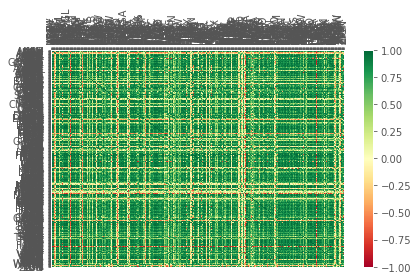

In [5]:
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    #df['AAPL'].plot()
    #plt.show()
    df_corr = df.corr()
    
    print(df_corr.head())
    
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    
    plt.xticks(rotation = 90)
    heatmap.set_clim(-1,1)
    
    plt.tight_layout()
    plt.show()
    
visualize_data()